In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
# sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

# Let's start with EDA

In [5]:
print(train.shape,test.shape)

(7613, 5) (3263, 4)


In [ ]:
dxxdcftrain.head(3)

In [ ]:
#Check if ther'is null values
train.isnull().sum()

In [6]:
#Remove redundant samples
train=train.drop_duplicates(subset=['text', 'target'], keep='first')
train.shape

(7521, 5)

* We have 92 redundants sapmles in our dataset

In [ ]:
train.target.value_counts()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('target').id.count().plot.bar(ylim=0)
plt.show()

* labels are not balanced

In [7]:
# Numbers of word for each sapmle in train & test data
train['text_length'] = train.text.apply(lambda x: len(x.split()))
test['text_length'] = test.text.apply(lambda x: len(x.split()))

In [ ]:
train['text_length'].describe()

In [ ]:
test['text_length'].describe()

* Max number of words in all data is 31 and min is 1!

In [ ]:
def plot_word_count(df, data_name):
  sns.distplot(df['text_length'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

In [ ]:
#ig = plt.figure(figsize=(16,6))
#plt.hist(train["text_length"], bins = 30)
#plt.show()
plt.subplot(1, 2, 1)
plot_word_count(train, 'Train')

plt.subplot(1, 2, 2)
plot_word_count(test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [8]:
# collecting all words in single list
list_= []
for i in train.text:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)

In [9]:
len(vocabulary)

31480

 * We have 31480 different words in our train data

In [10]:
def create_corpus(df,target):
    corpus=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

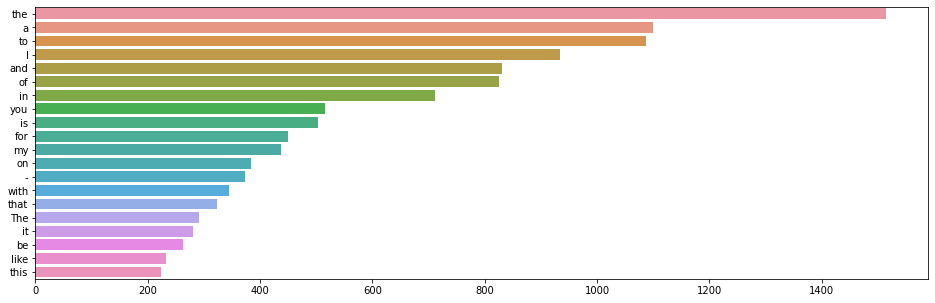

In [11]:
#most frequent 20 words when label == 0 
import collections
allWords=create_corpus(train,target=0)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

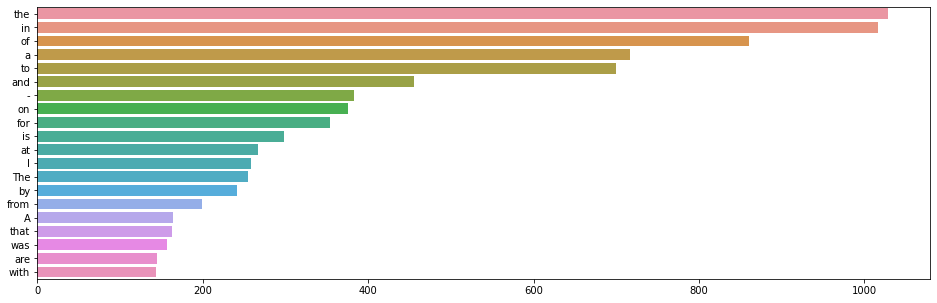

In [12]:
#most frequent 20 words when label == 1 
import collections
allWords=create_corpus(train,target=1)
vocabulary= set(allWords)
vocabulary_list= list(vocabulary)

plt.figure(figsize=(16,5))
counter=collections.Counter(allWords)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
  x.append(word)
  y.append(count)
sns.barplot(x=y,y=x)

# Data Cleaning

## 1-Removing Punctuations

In [13]:
#List of punctuations and we will remove them from our corpus
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
#for  example
text='hey # how are !you doing ?'
"".join([char for char in text if char not in string.punctuation])

'hey  how are you doing '

## 2-Removing Numbers

In [15]:
#for example 
text='hey 4 look 333 at me0'
re.sub('[0-9]', '', text)

'hey  look  at me'

## 3-Removing Stopwords

In [16]:
#list of stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
#for example
text='hey this is me and I am here to help you  '
tokens = word_tokenize(text)
tokens=[word for word in tokens if word not in stopwords.words('english')]
' '.join(tokens)

'hey I help'

## Now let's Build a function that clean our data

* I just added lower function in order to lowercase all words and stemming

In [18]:
pstem = PorterStemmer()
def clean_text(text):
    text= text.lower()
    text= re.sub('[0-9]', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens=[pstem.stem(word) for word in tokens]
    #tokens=[word for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [19]:
clean_text("hey I am here # ! looks 4 GOOD can't see you!")

'hey i am here look good cant see you'

In [20]:
train["clean"]=train["text"].apply(clean_text)
test["clean"]=test["text"].apply(clean_text)

In [21]:
#Let's see the effect of cleaning
train[["text","clean"]].head(4)

,text,clean
0,Our Deeds are the Reason of this #earthquake M...,our deed are the reason of thi earthquak may a...
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,all resid ask to shelter in place are be notif...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order in california


In [22]:
# collecting all words in single list
list_= []
for i in train.clean:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)
len(vocabulary)

20163

* we reduced our data from 31480 unique words to 19920

In [23]:
tfidf = TfidfVectorizer(sublinear_tf=True,max_features=60000, min_df=1, norm='l2',  ngram_range=(1,2))
features = tfidf.fit_transform(train.clean).toarray()
features.shape

(7521, 60000)

In [24]:
features_test = tfidf.transform(test.clean).toarray()

# Let's use some machine leaning algorithm

In [25]:
#split data into 4 parts with same distribution of classes.
skf = StratifiedKFold(n_splits=4, random_state=48, shuffle=True)
accuracy=[] # list contains the accuracy for each fold
n=1
y=train['target']

In [27]:
for trn_idx, test_idx in skf.split(features, y):
  start_time = time()
  X_tr,X_val=features[trn_idx],features[test_idx]
  y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
  model= LogisticRegression(max_iter=1000,C=3)
  #model=MultinomialNB(alpha=0.5)
  #model=svm.SVC(max_iter=1000)
  model.fit(X_tr,y_tr)
  s = model.predict(X_val)
  # sub[str(n)]= model.predict(features_test) 
  
  accuracy.append(accuracy_score(y_val, s))
  print((time() - start_time)/60,accuracy[n-1])
  n+=1

0.42953121264775596 0.809144072301967
0.3416605194409688 0.8021276595744681
0.44699813922246295 0.7968085106382978
0.3922463337580363 0.8


In [28]:
accuracy

[0.809144072301967, 0.8021276595744681, 0.7968085106382978, 0.8]

In [29]:
np.mean(accuracy)*100

80.20200606286832

In [30]:
import joblib

joblib.dump(model, 'model.h5')

['model.h5']

In [34]:
joblib.dump(tfidf, 'vectorier.h5')

['vectorier.h5']

# Evaluating Model on Validation Set

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
pred_valid_y = model.predict(X_val)
print(classification_report(y_val, pred_valid_y ))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1079
           1       0.86      0.63      0.73       801

    accuracy                           0.80      1880
   macro avg       0.82      0.78      0.79      1880
weighted avg       0.81      0.80      0.79      1880



In [33]:
print(confusion_matrix(y_val, pred_valid_y ))

[[998  81]
 [295 506]]


# Submission

In [ ]:
sub

In [ ]:
df=sub[['1','2','3','4']].mode(axis=1)# select the most frequent predicted class by our model
sub['target']=df[0]    
sub=sub[['id','target']]
sub['target']=sub['target'].apply(lambda x : int(x))

In [ ]:
sub.to_csv('submission.csv',index=False)

In [37]:
a = joblib.load('./vectorier.h5')

# Please If you find this kernel helpful, upvote it to help others see it 😊

In [42]:
data = pd.Series(data = "hello my name is ashwin")
data = a.transform(data)
model.predict(data)

array([0])

In [39]:
train.clean

0       our deed are the reason of thi earthquak may a...
1                    forest fire near la rong sask canada
2       all resid ask to shelter in place are be notif...
3          peopl receiv wildfir evacu order in california
4       just got sent thi photo from rubi alaska as sm...
                              ...                        
7604    worldnew fallen powerlin on glink tram updat f...
7605    on the flip side im at walmart and there is a ...
7606    suicid bomber kill in saudi secur site mosqu r...
7608    two giant crane hold a bridg collaps into near...
7612    the latest more home raze by northern californ...
Name: clean, Length: 7521, dtype: object

0    hello my name is ashwin
dtype: object